We can implement **OneClassSVM** model or **One-Class CNN** model for detecting defects on fabric.
Also we can use **Gabor filters** to detect. However, input images come in different orientations and scales which makes the use of gabor filters ineffective.

OC-SVM takes more time and uses more source than OC-CNN. First we try OneClassSVM but we failed. We know that Gabor filters are ineffective so we chose the OC-CNN side.

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from sklearn.datasets import load_files
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from skimage.color import rgb2gray
from sklearn.metrics import classification_report
from tensorflow.keras import datasets, layers, models, optimizers, regularizers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm

SHAPE = (128, 128)




**1.   Data Preprocessing**



In [ ]:
def loadImage(path):
  img = image.load_img(path, target_size=SHAPE, color_mode='grayscale')
  return image.img_to_array(img)

def loadData(path):
  data = load_files(path)
  f = np.array(data['filenames'])
  t = np.array(data['target'])
  f_arr = tqdm(f, desc='Data loading', leave=True)
  img_data = [loadImage(p)/255 for p in f_arr]
  return np.array(img_data), np.array(t)

# --- Loading all the good fabric data and split to train and test. --- #
x_good, y_good = loadData("/content/drive/MyDrive/FabricDataset/all_good")
x_train, x_test, y_train, y_test = train_test_split(x_good, y_good, shuffle=True, test_size= .25)
print(f'Shape of x_train = {x_train.shape}')
print(f'Shape of x_test = {x_test.shape}')
print(f'Shape of y_train = {y_train.shape}')
print(f'Shape of y_test = {y_test.shape}')

print("\n")

# --- Loading all the bad fabric data and concat to test. --- #
x_bad, y_bad = loadData("/content/drive/MyDrive/FabricDataset/all_bad")
x_test = np.concatenate((x_test, x_bad), axis=0)
y_test = np.concatenate((y_test, y_bad), axis=0)

x_test, y_test = shuffle(x_test, y_test)

print(f'\nShape of x_train = {x_train.shape}')
print(f'Shape of x_test = {x_test.shape}')
print(f'Shape of y_train = {y_train.shape}')
print(f'Shape of y_test = {y_test.shape}')

n_train = x_train.shape[0]
n_test = x_test.shape[0]


Data loading: 100%|██████████| 493/493 [00:08<00:00, 60.53it/s]


Shape of x_train = (369, 128, 128, 1)
Shape of x_test = (124, 128, 128, 1)
Shape of y_train = (369,)
Shape of y_test = (124,)




Data loading: 100%|██████████| 56/56 [00:00<00:00, 270.28it/s]


Shape of x_train = (369, 128, 128, 1)
Shape of x_test = (180, 128, 128, 1)
Shape of y_train = (369,)
Shape of y_test = (180,)


**2. Creating the Model**\
*Note:* We didn't design the model. We just optimize the dropout, learning rate values and optimizer.

In [ ]:
def create_model(image_shape = (64, 64, 1), print_summary=False, lr=0.0001):
    # Initial model
    model = models.Sequential()
    # CONV layer: filter 32, stride 3x3
    model.add(layers.Conv2D(32, (3, 3),input_shape=image_shape))
    #model.add(layers.BatchNormalization())
    model.add(layers.Activation("relu"))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.2))

    # CONV layer: filter 32, stride 3x3
    model.add(layers.Conv2D(32, (3, 3)))
    model.add(layers.Activation("relu"))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.2))

    # CONV layer: filter 64, stride 3x3
    model.add(layers.Conv2D(64, (3, 3)))
    #model.add(layers.BatchNormalization())
    model.add(layers.Activation("relu"))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.2))

    model.add(layers.Flatten())

    # Fully connected layer -> nn layer with 64 nodes
    model.add(layers.Dense(64))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation("relu"))
    model.add(layers.Dropout(.5))

    # Output layer
    model.add(layers.Dense(1, activation="sigmoid"))

    # Set model compiler
    model.compile(optimizer="SGD", loss="binary_crossentropy", metrics=["accuracy"])

    # Show the CNN model detail
    if print_summary:
        model.summary()

    return model

model = create_model(image_shape=(SHAPE[0],SHAPE[1],1),print_summary= True, lr = 0.00001)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      320       
                                                                 
 activation (Activation)     (None, 126, 126, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 61, 61, 32)        0         
                                                        

In [ ]:
def train_model(model, x_train, y_train, x_val, y_val, n_epoch, batch_size):
    history = model.fit(x_train, y_train, epochs=n_epoch, batch_size=batch_size,
                        shuffle= True, validation_data=(x_val, y_val))
    return history

In [ ]:
# Train CNN model
n_epoch = 5
batch_size = 30

history = train_model(model, x_train, y_train, x_test, y_test, n_epoch, batch_size)

Epoch 1/5
13/13 [==============================] - 14s 696ms/step - loss: 1.0022 - accuracy: 0.4092 - val_loss: 0.6512 - val_accuracy: 0.6889
Epoch 2/5
13/13 [==============================] - 11s 790ms/step - loss: 0.6101 - accuracy: 0.6694 - val_loss: 0.6247 - val_accuracy: 0.6889
Epoch 3/5
13/13 [==============================] - 11s 857ms/step - loss: 0.4113 - accuracy: 0.8130 - val_loss: 0.6205 - val_accuracy: 0.6889
Epoch 4/5
13/13 [==============================] - 10s 794ms/step - loss: 0.2975 - accuracy: 0.9051 - val_loss: 0.6196 - val_accuracy: 0.6889
Epoch 5/5
13/13 [==============================] - 9s 631ms/step - loss: 0.2522 - accuracy: 0.9295 - val_loss: 0.6193 - val_accuracy: 0.6889


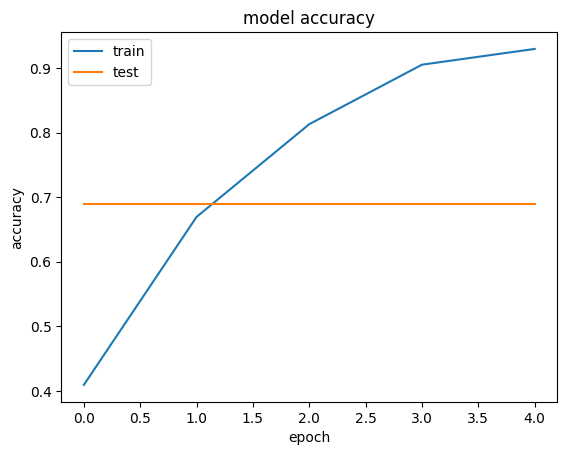

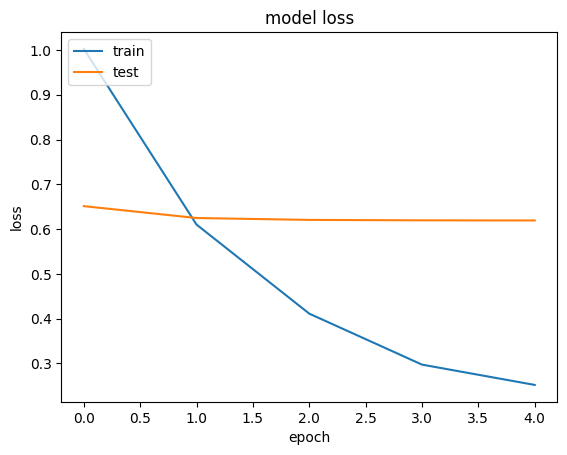

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()